# mHSP2: Extract Standalone Results

An example of extracting standalone results from **mHSP2**.

## Imports and Parameters

In [1]:
%matplotlib inline

In [2]:
from IPython.display import display, HTML
import numpy as np
import pandas as pd
import datetime as dt
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import os
from shapely.geometry import Polygon, Point
import pickle
import matplotlib.tri as tri
import datetime as dt
from copy import deepcopy

In [3]:
import flopy

flopy is installed in C:\ProgramData\Anaconda3\lib\site-packages\flopy


In [4]:
# Absolute path to HSPF and associated parameters
HSPF_Dir = r'C:\Working\Test_Models\modSA_mHSP2'
HSPF_HDF5 = "DC_CalibmHSP2.h5"
GAUGE_XLSX = r'C:\Working\Test_Models\modSA_mHSP2\DolanProcessed_Hr-Processed.xlsx'
GAUGE_SHT = "Daily"
GAUGE_HDR = "Discharge_cfs"

In [5]:
OUT_DIR = r'C:\Working\Test_Models\modSA_mHSP2\Outputs'

In [6]:
ConvAFDtoCFS = lambda AFD: ( AFD * ( 43560.0 / 1.0**2 ) ) * ( 1.0 / (24.0 * 60.0 * 60.0 ) ) 
ConvAFtoCM = lambda AF: AF * 1233.48185532
ConvCMDtoCFS = lambda CMD: ( CMD * ( 35.3147 / 1.0**3 ) ) * ( 1.0 / (24.0 * 60.0 * 60.0 ) ) 

In [7]:
CStart_DT = dt.datetime( 2013, 7, 1 )
CEnd_DT = dt.datetime( 2018, 7, 1 )

## Load Simulation Results and Data

Load the HSPF results from the HDF5 file

In [8]:
InStore = os.path.normpath( os.path.join( HSPF_Dir, HSPF_HDF5 ) )
with pd.HDFStore( InStore ) as store:
    H_RR5 = store.get(key=r'/RESULTS/RCHRES_R005/HYDR/')
# end with and close the file

In [9]:
H_RR5["ovol_cfs"] = H_RR5.apply( lambda row: ConvAFDtoCFS( row["OVOL1"] ), axis=1 )

In [10]:
H_RR5 = H_RR5.loc[CStart_DT:CEnd_DT].copy()

In [11]:
display( HTML( H_RR5.describe().to_html() ) )

,DEP,IVOL,O1,OVOL1,PRSUPY,RO,ROVOL,SAREA,VOL,VOLEV,ovol_cfs
count,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000,1827.000000
mean,2.603622,28.492222,14.221018,28.207014,0.188241,14.221018,28.207014,33.589439,266.435150,0.473762,14.221026
std,0.085865,7.578643,3.817648,7.572196,0.722031,3.817648,7.572196,0.089827,2.856511,0.163473,3.817648
min,2.473819,23.820107,11.687729,23.182272,0.000000,11.687729,23.182272,33.450912,262.141998,0.109892,11.687729
25%,2.549476,25.679740,12.776174,25.341171,0.000000,12.776174,25.341171,33.532150,264.640076,0.315787,12.776174
50%,2.600850,27.246685,13.515259,26.807123,0.000000,13.515259,26.807123,33.587315,266.336365,0.520775,13.515258
75%,2.638278,28.701836,14.432969,28.627376,0.000090,14.432969,28.627376,33.626926,267.576721,0.617765,14.432969
max,3.193897,108.144325,54.326874,107.755783,9.243500,54.326874,107.755783,34.197098,286.186920,0.775804,54.326874


In [12]:
H_DSprings = pd.read_hdf( InStore, key=r'/TIMESERIES/TS136/')

In [13]:
type(H_DSprings)

pandas.core.series.Series

In [14]:
H_DSprings.index[:5]

DatetimeIndex(['1980-01-01', '1980-01-02', '1980-01-03', '1980-01-04',
               '1980-01-05'],
              dtype='datetime64[ns]', name='Datetime', freq='D')

In [15]:
H_DSprings.values

array([24.21453563, 24.16047762, 24.10736857, ..., 23.25454552,
       23.24704467, 23.24150613])

Make a DataFrame

In [16]:
DataDict = { "ExtIn_afd" : np.array( H_DSprings.values, dtype=np.float32 ), }
H_RR5_ExIn = pd.DataFrame( index=H_DSprings.index, data=DataDict )

In [17]:
H_RR5_ExIn["ovol_cfs"] = H_RR5_ExIn.apply( lambda row: ConvAFDtoCFS( row["ExtIn_afd"] ), axis=1 )

In [18]:
H_RR5_ExIn = H_RR5_ExIn.loc[CStart_DT:CEnd_DT].copy()

In [19]:
display( HTML( H_RR5_ExIn.describe().to_html() ) )

,ExtIn_afd,ovol_cfs
count,1827.000000,1827.000000
mean,24.909149,12.558361
std,1.203387,0.606707
min,23.195240,11.694267
25%,23.710787,11.954188
50%,24.910954,12.559272
75%,26.088001,13.152701
max,26.784445,13.503824


Make continuous lists so that can use "fill"

In [20]:
lenBF = len( H_RR5_ExIn )
lenBF

1827

In [21]:
DTTimeList = list( H_RR5_ExIn.index.to_pydatetime() )
type(DTTimeList)

list

In [22]:
BackDTList = deepcopy( DTTimeList )
BackDTList = BackDTList[::-1]
BackDTList[:5]

[datetime.datetime(2018, 7, 1, 0, 0),
 datetime.datetime(2018, 6, 30, 0, 0),
 datetime.datetime(2018, 6, 29, 0, 0),
 datetime.datetime(2018, 6, 28, 0, 0),
 datetime.datetime(2018, 6, 27, 0, 0)]

In [23]:
ZeroVals = [ 0.0 for x in range( lenBF ) ]
DSVals = list( H_RR5_ExIn["ovol_cfs"].to_numpy() )
DSVals = DSVals[::-1]
DSVals[:5]

[12.178044247627257,
 12.203668578465779,
 12.229670826594035,
 12.256020220120748,
 12.282683102289836]

In [24]:
ValsList = deepcopy( ZeroVals )
ValsList.extend( DSVals )
DTTimeList.extend( BackDTList )

Load the gauge data

In [25]:
DCGauge = pd.read_excel( GAUGE_XLSX, sheet_name=GAUGE_SHT, header=0, index_col=0, parse_dates=True )

C:\ProgramData\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\ProgramData\Anaconda3\lib\site-packages\xlrd\xlsx.py:312: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():
C:\ProgramData\Anaconda3\lib\site-packages\xlrd\xlsx.py:266: PendingDeprecationWarning: This method will be removed in future versions.  Use 'tree.iter()' or 'list(tree.iter())' instead.
  for elem in self.tree.iter() if Element_has_iter else self.tree.getiterator():


In [26]:
DCGauge = DCGauge[[GAUGE_HDR]].loc[CStart_DT:CEnd_DT].copy()

In [27]:
display( HTML( DCGauge.describe().to_html() ) )

,Discharge_cfs
count,1827.000000
mean,14.924813
std,4.637589
min,8.030938
25%,11.859896
50%,13.535417
75%,16.627604
max,44.078827


## Plots

In [28]:
OutSVG = os.path.normpath( os.path.join( OUT_DIR, "HSPF_SA_Calib.svg" ) )
OutSVG

'C:\\Working\\Test_Models\\modSA_mHSP2\\Outputs\\HSPF_SA_Calib.svg'

In [29]:
OutPNG = os.path.normpath( os.path.join( OUT_DIR, "HSPF_SA_Calib.png" ) )
OutPNG

'C:\\Working\\Test_Models\\modSA_mHSP2\\Outputs\\HSPF_SA_Calib.png'

In [30]:
disTicks = [ 5.0, 10.0, 50.0, 100.0 ]

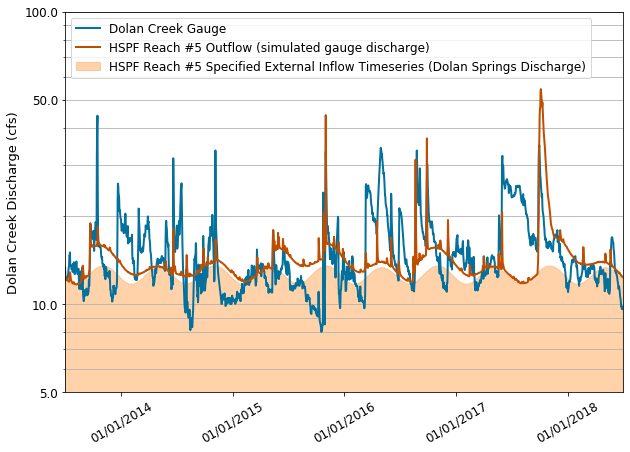

In [31]:
Fig1 = plt.figure()
Fig1.set_size_inches(10.0, 7.0)
ax11 = Fig1.add_subplot(111)
Dcg, = ax11.plot( DCGauge.index, DCGauge[GAUGE_HDR], color='xkcd:ocean blue', linewidth=2,
                  label="Dolan Creek Gauge" )
Rc5, = ax11.plot( H_RR5.index, H_RR5["ovol_cfs"], color='xkcd:burnt orange', linewidth=2,
                  label="HSPF Reach #5 Outflow (simulated gauge discharge)" )
sfF = ax11.fill( DTTimeList, ValsList, color='xkcd:pale orange', alpha=0.5, 
                 label="HSPF Reach #5 Specified External Inflow Timeseries (Dolan Springs Discharge)")
#ax11.legend( (Dcg, Rc5 ), 
#             ("Dolan Creek Gauge", "Simulated Reach 5 outflow" ),
#             loc='upper center', fontsize=12)
ax11.legend(loc='upper left', fontsize=12)
ax11.set_yscale('log')
ax11.grid(b=True, which="both", axis='y')
ax11.set_ylim( ( 5.0, 100.0))
ax11.set_xlim( (CStart_DT, CEnd_DT))
ax11.set_yticks( disTicks )
ax11.set_ylabel('Dolan Creek Discharge (cfs)', fontsize=13)
ax11.tick_params(axis='both', which='major', labelsize=12)
ax11.tick_params(axis='x', which='major', labelrotation=30.0)
ax11.xaxis.set_major_formatter( mpl.dates.DateFormatter("%m/%d/%Y") )
ax11.yaxis.set_major_formatter( mpl.ticker.StrMethodFormatter( "{x:,.1f}" ) )
Fig1.savefig( OutSVG )
Fig1.savefig( OutPNG )